<h1>Diversifying Parameters in Reinforcement Learning</h1>

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import torch
import matplotlib
#matplotlib.use("Agg")

torch.manual_seed(0)

<h2>Helper Functions</h2>

In [2]:
def step(t):
    return round(t / dt)

def gen_state(ps):
    rand = np.random.random()
    c_ps = np.cumsum(ps)
    return np.argmax(rand < c_ps)

#return learning rate
def alpha_c(bl, delta, c):
    if bl:
      #step function
      if delta > 0:
          return 0
      else:
          return 1
    else:
      return 1 / (1 + math.exp(-c * delta))

def ret_apos(sc, aneg):
    return (sc * aneg) / (1 - sc)

def compare_floats(float1, float2, error):
    return abs(float1 - float2) <= error

def task_probs(tsk):
  if tsk == "hyp_unif":
    return [1]
  if tsk == "hyp_var":
    return [1]
  elif tsk == "var":
    return [1]
  elif tsk == "delay":
    return [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]

def gen_rew(tsk):
  if tsk == "hyp_unif":
    return s_rew[i, 0]
  if tsk == "hyp_var":
    return torch.normal(s_rew[i, 0], s_rew[i, 1]) 
  elif tsk == "var":
    return s_rew[0, gen_state(s_rew[1,:])]
  elif tsk == "delay":
    return 0
  

def create_valueatstep(state, step, n_steps, diversify=["none"]):
  deg_free = len(diversify)

  predictors = []
  tls = [index for index, value in enumerate(states) if value == state]

  for i in range(n_predictors):
    value = []
    for s in range(n_steps):
      value.append(V[i, state, tls[s], step].item())
    predictors.append(value)

  fig, ax = plt.subplots()

  normalized_value = 0
  for i in range(len(predictors)):
    if diversify[0] == "alpha":
      normalized_value = alphas[i, 0].item() / (alphas[i, 0].item()  + alphas[i, 1].item() )
      pass
    elif diversify[0] == "gamma":
      normalized_value = gammas[i].item()
      pass
    elif diversify[0] == "lmbda":
      normalized_value = lmbdas[i].item()
      pass
    plt.plot(predictors[i], color=plt.cm.jet(normalized_value))

  # Create a normalized color map using Normalize class
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])

  cbar = plt.colorbar(sm)
  cbar.set_label('Color Range')

  ax.set_xlabel('Number of trials')
  ax.set_ylabel('Value')
  ax.set_title(f'{diversify} Value of Value Predictors (n={n_predictors}) at Time of Stim, {n_steps} pos Trials')
  #ax.set_title(f'TD Error (n={n_predictors}) at Time of Reward, {len(delta_list[0][state])} {state} Trials')
  ax.grid(True)

  plt.legend()
  plt.show()

def heatmaps(state, prs, diversify=["none"]):
  deg_free = len(diversify)

  tls = [index for index, value in enumerate(states) if value == state]
  for i in prs:
    td_i = deltas[i, state, tls, :]
    n = td_i.shape[0]

    if deg_free == 2:
      if (diversify[0] == "alpha" or diversify[1] == "alpha") and (diversify[0] == "gamma" or diversify[1] == "gamma"):
        alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()  + alphas[i, 1].item() )
        plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")
        pass
      elif (diversify[0] == "alpha" or diversify[1] == "alpha") and (diversify[0] == "lambda" or diversify[1] == "lambda"):
        alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()  + alphas[i, 1].item() )
        plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")
        pass
      elif (diversify[0] == "lambda" or diversify[1] == "lambda") and (diversify[0] == "gamma" or diversify[1] == "gamma"):
        plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gammas[i].item():.2f}, lambda: {lmbdas[i].item():.2f}")
        pass
    elif deg_free == 1:
      if diversify[0] == "alpha":
        alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()  + alphas[i, 1].item() )
        plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gamma}, lambda: {lmbda}")
        pass
      elif diversify[0] == "gamma":
        plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")
        pass
      elif diversify[0] == "lmbda":
        plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gamma}, lambda: {lmbdas[i].item():.2f}")
        pass

    plt.imshow(td_i, cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xlabel('Step')
    plt.ylabel('Trial')
    plt.show()


def reward(n_trials, r, t_rew):
    """
    Plots the graph of reward over time.

    Parameters:
    T (numpy array): Time vector.
    r (numpy array): Reward vector.
    t_rew (numpy array): Time steps where rewards are recorded.

    Returns:
    None (displays the plot)
    """
    # Get the index of the step where rewards are recorded
    t_rew_step = step(t_rew[0].item()) - 1

    # Get the rewards corresponding to the recorded time steps
    rewards = r[0, :, t_rew_step]

    # Create the plot
    plt.plot(range(n_trials), rewards)
    plt.xlabel('Time')
    plt.ylabel('Reward')
    plt.title('Reward Over Time')
    plt.grid(True)
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

# Sample data for three lines (x-values and y-values)
x_data = np.linspace(0, 10, 100)
y1_data = np.sin(x_data)
y2_data = np.cos(x_data)
y3_data = np.sin(2 * x_data)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Initialize the line objects for each line you want to plot
line1, = ax.plot(x_data, y1_data, label='Line 1')
line2, = ax.plot(x_data, y2_data, label='Line 2')
line3, = ax.plot(x_data, y3_data, label='Line 3')

# Create alphas as a 2D array with values between 0 and 1 for each line
alphas = np.random.rand(3, 1)

# Create a scalar mappable to map values from alphas to colormap
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
sm.set_array([])

def update(frame):
    # Update the y-data for each line
    line1.set_ydata(np.sin(x_data + frame * 0.1))  # Example of a dynamic change
    line2.set_ydata(np.cos(x_data + frame * 0.2))  # Example of another dynamic change
    line3.set_ydata(np.sin(2 * x_data + frame * 0.15))  # Example of a different dynamic change

    # Update the color of each line based on its corresponding alpha value
    line1.set_color(plt.cm.jet(alphas[0, 0]))
    line2.set_color(plt.cm.jet(alphas[1, 0]))
    line3.set_color(plt.cm.jet(alphas[2, 0]))
    
    return line1, line2, line3

# Set up the animation with the update function and the number of frames
ani = FuncAnimation(fig, update, frames=len(x_data), interval=100, blit=True)

# Close the static plot window
plt.close()

# Display the animation as HTML in Jupyter Notebook
HTML(ani.to_jshtml())


<h2>Coding Trials</h2>

In [3]:
#Simulations
n_trials = 150
t_int = 10 # length of trial
dt = 1 # timestep size
tsk = "hyp_var"

types = 4
t_stim = torch.full((types,), 2)
t_rew = torch.full((types,), 6)
s_rew = torch.tensor([[1, 0.1], [0.5, 0.1], [0, 0.1], [-1, 0.1]])
n_predictors = 50 # number of value predictors


In [4]:
# #Variable Magnitude Reward Task Simulations

# n_trials = 1000
# t_int = 7 # length of trial
# dt = 1 # timestep size
# tsk = "var"

# types = 1
# t_stim = torch.full((types,), 2)
# t_rew = torch.full((types,), 6)
# s_rew = torch.tensor([[0.1, 0.06612594], [0.3, 0.09090909], [1.2, 0.14847358], [2.5, 0.15489467], [5, 0.31159175], [10, 0.150519], [20, 0.07705306]])
# n_predictors = 50 # number of value predictors


In [5]:
#Delay Discounted Reward Task Simulations

<h2>Single Parameters</h2>

<h3>Alpha</h3>

In [6]:
#model params
gamma = 0.8   # discount factor
alphas = torch.rand(n_predictors, 2) # learning rate
lmbda = 0.2    # eligibility trace

#################################################################

steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


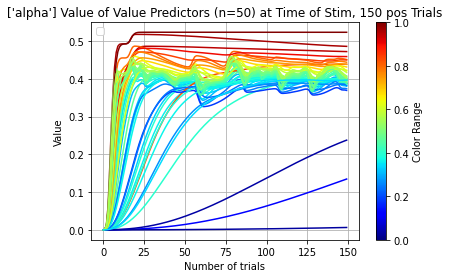

In [7]:
st = 0
t = step(t_stim[st].item()) - 1
steps = 150

create_valueatstep(st, t, steps, diversify=["alpha"])


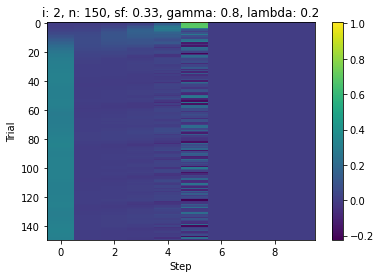

In [8]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["alpha"])

<h3>Gamma</h3>

In [9]:
#model params 
#gamma = 0.4   discount factor IS DISTRIBUTED BELOW
alpha = 0.5 # learning rate 
lmbda = 0.3 # eligibility trace
n_predictors = 50 # number of value predictors

####################################################

steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
#alpha step function
gammas = torch.rand(n_predictors, 1)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


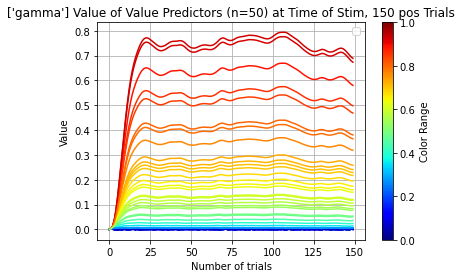

In [10]:
st = 0
t = step(t_stim[st].item()) - 1
steps = 150

create_valueatstep(st, t, steps, diversify=["gamma"])

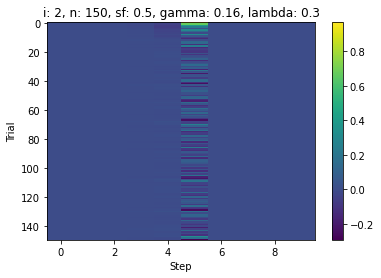

In [11]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["gamma"])

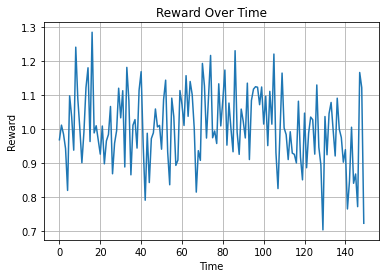

In [12]:
reward(n_trials, r, t_rew)

<h3>Lambda</h3>

In [13]:
types = 4
t_stim = torch.full((types,), 3)
t_rew = torch.full((types,), 7)
s_rew = torch.tensor([[1, 0.1], [0.5, 0.1], [0, 0.1], [-1, 0.1]])

#model params 
gamma = 0.7  #discount factor
alpha = 0.1 # learning rate 
lmbdas = torch.rand(n_predictors, 1) #eligibility traces DISTRIBUTED
n_predictors = 50 # number of value predictors


########################################################

steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#return learning rate
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


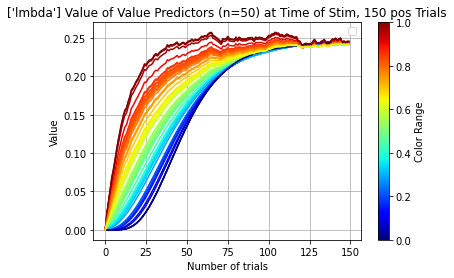

In [14]:
st = 0
t = step(t_stim[st].item()) - 1
steps = 150

create_valueatstep(st, t, steps, diversify=["lmbda"])

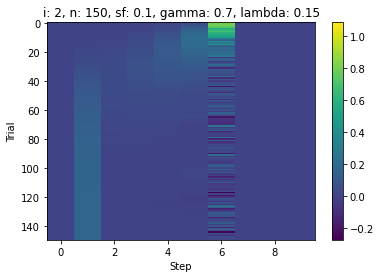

In [15]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["lmbda"])

<h2>Multiple Parameters</h2>

<h3>Alpha and Gamma</h3>

<h4>Discrete Alpha</h4>

In [16]:
#model params 
gammas = torch.rand(n_predictors, 1) #discount factor 
alphas_sc = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)])
lmbda = 0.3 # eligibility trace
n_predictors = 50 # number of value predictors

#################################################

steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
alphas = torch.rand(n_predictors, 2)
for i in range(alphas.shape[0]):
    alphas[i, 0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())
    while alphas[i, 0].item() > 1:
        alphas[i, 1] = random.random()
        alphas[i ,0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

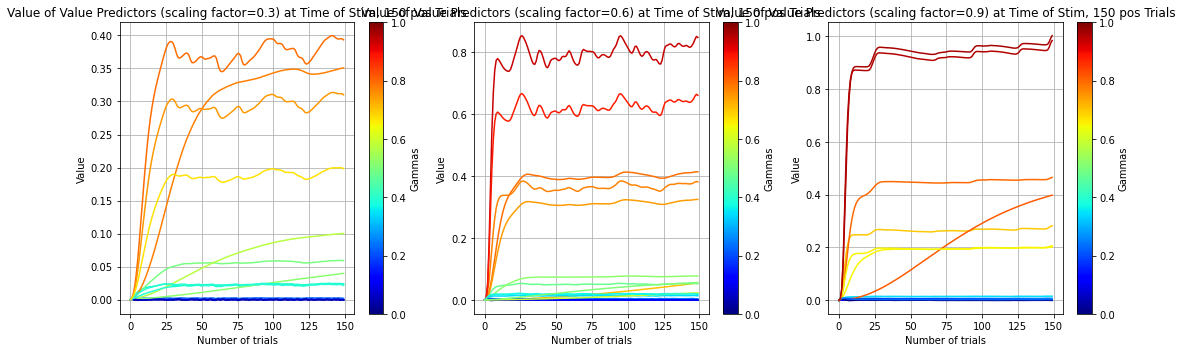

In [17]:
st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of scaling factors
scs = [0.3, 0.6, 0.9]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

for i, sc in enumerate(scs):
  predictors_sc = []

  # Filter predictors based on the current gamma value
  predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (scaling factor={sc}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_sc):
    gm = gammas[predictor[0]].item()
    color = plt.cm.jet(gm)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Gammas')

plt.tight_layout()
plt.show()

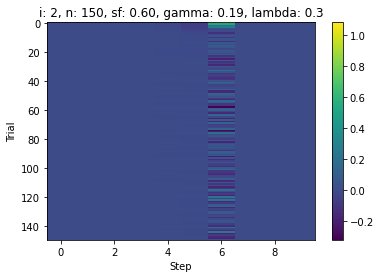

In [18]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["alpha", "gamma"])

<h4>Discrete Gamma</h4>

In [19]:
#model params 
gammas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) #discount factor 
alphas = torch.rand(n_predictors, 2) #learning rate
lmbda = 0.3 # eligibility trace
n_predictors = 50 # number of value predictors

#################################################


steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

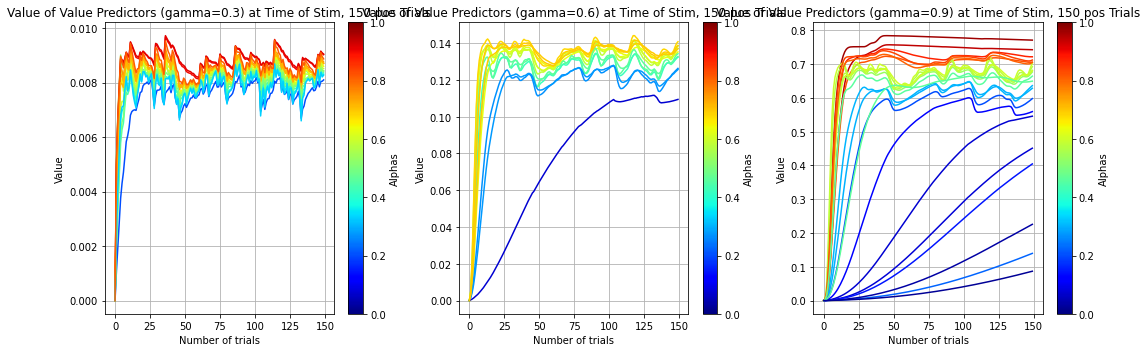

In [20]:
st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of gamma
gms = [0.3, 0.6, 0.9]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(gms), figsize=(15, 5))

for i, gamma in enumerate(gms):
  predictors_gamma = []

  # Filter predictors based on the current gamma value
  predictors_gamma = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(gammas[j].item(), gamma, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (gamma={gamma}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_gamma):
    scaling_factor = (alphas[predictor[0], 0].item() / (alphas[predictor[0], 0].item() + alphas[predictor[0], 1].item()))
   # print(f'{predictor[0]} : {scaling_factor}')
    color = plt.cm.jet(scaling_factor)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Alphas')

plt.tight_layout()
plt.show()

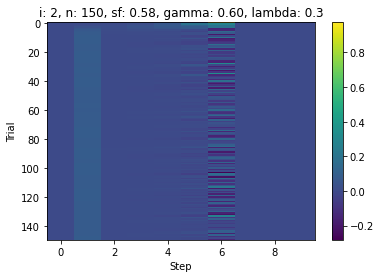

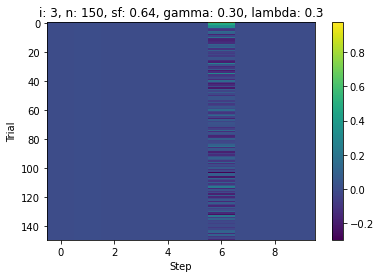

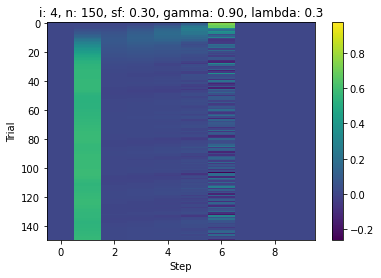

In [21]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["alpha", "gamma"])

<h3>Alpha and Lambda</h3>

<h4>Discrete Alpha</h4>

In [22]:
#model params 
n_predictors = 50 # number of value predictors
gamma = 0.7   #discount factor 
alphas_sc = torch.tensor([random.choice([0.2, 0.4, 0.6]) for _ in range(n_predictors)])
lmbdas = torch.rand(n_predictors, 1)

#################################################


steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
alphas = torch.rand(n_predictors, 2)
for i in range(alphas.shape[0]):
    alphas[i, 0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())
    while alphas[i, 0].item() > 1:
        alphas[i, 1] = random.random()
        alphas[i ,0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


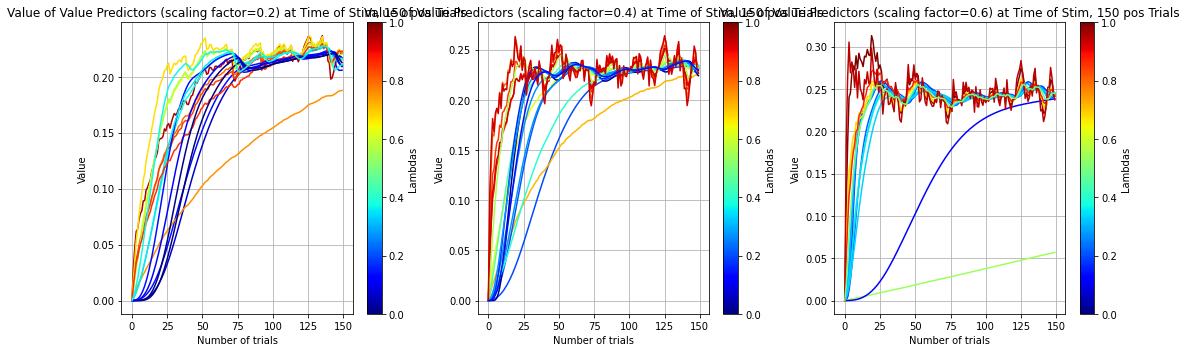

In [23]:
st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of scaling factors
scs = [0.2, 0.4, 0.6]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

for i, sc in enumerate(scs):
  predictors_sc = []

  # Filter predictors based on the current gamma value
  predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (scaling factor={sc}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_sc):
    lm = lmbdas[predictor[0]].item()
    color = plt.cm.jet(lm)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Lambdas')

plt.tight_layout()
plt.show()

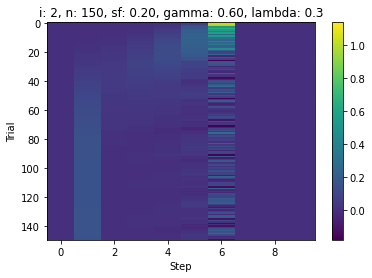

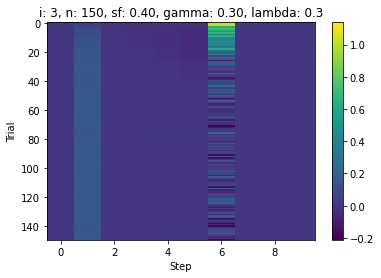

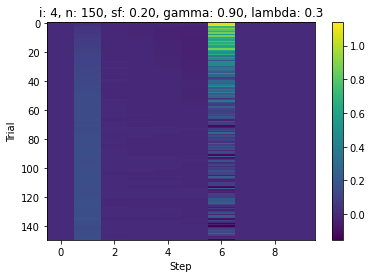

In [24]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "alpha"])

<h4>Discrete Lambda</h4>

In [25]:
#model params 
n_predictors = 50 # number of value predictors
gamma = 0.4   #discount factor 
alphas = torch.rand(n_predictors, 2)
lmbdas = torch.tensor([random.choice([0.2, 0.4, 0.6]) for _ in range(n_predictors)])

#################################################


steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


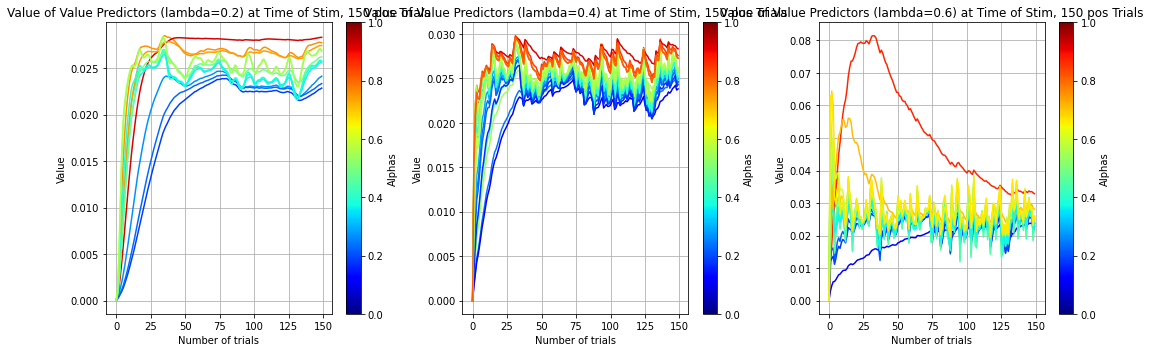

In [26]:

st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of gamma
lams = [0.2, 0.4, 0.6]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(lams), figsize=(15, 5))

for i, l in enumerate(lams):
  predictors_lambda = []

  # Filter predictors based on the current gamma value
  predictors_lambda = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(lmbdas[j].item(), l, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (lambda={l}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_lambda):
    scaling_factor = (alphas[predictor[0], 0].item() / (alphas[predictor[0], 0].item() + alphas[predictor[0], 1].item()))
    color = plt.cm.jet(scaling_factor)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Alphas')

plt.tight_layout()
plt.show()

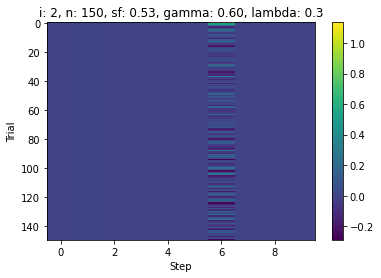

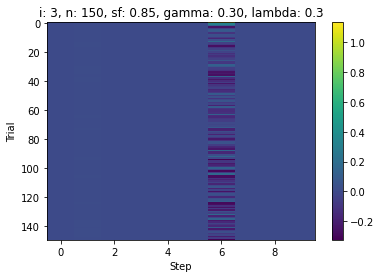

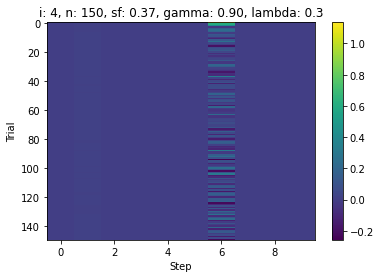

In [27]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "alpha"])

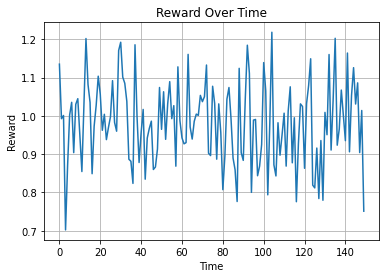

In [28]:
reward(n_trials, r, t_rew)

<h3>Gamma and Lambda</h3>

<h4>Discrete Gamma</h4>

In [29]:
#model params 
gammas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) #discount factor 
alpha = 0.05 #learning rate
lmbdas = torch.rand(n_predictors, 1) # eligibility trace
n_predictors = 50 # number of value predictors

#################################################


steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

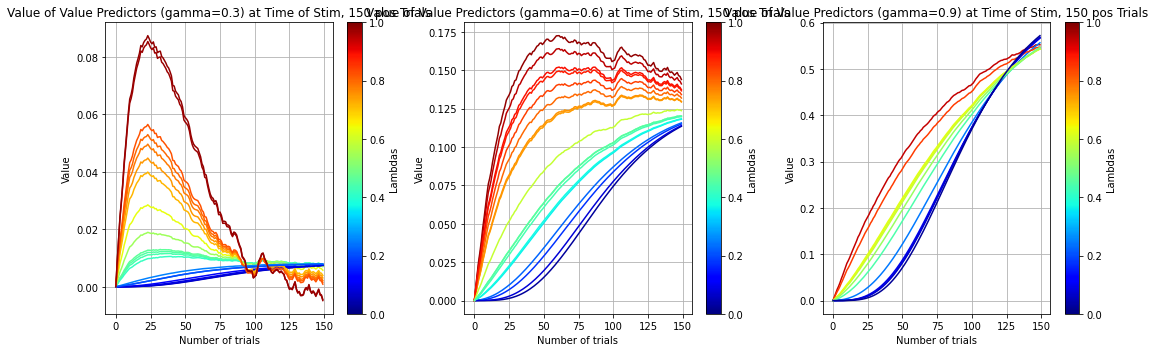

In [30]:
st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of scaling factors
gms = [0.3, 0.6, 0.9]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

for i, g in enumerate(gms):
  predictors_sc = []

  # Filter predictors based on the current gamma value
  predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(gammas[j].item(), g, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (gamma={g}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_sc):
    lm = lmbdas[predictor[0]].item()
    color = plt.cm.jet(lm)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Lambdas')

plt.tight_layout()
plt.show()

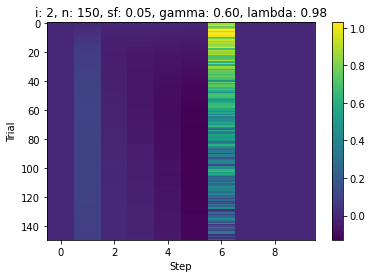

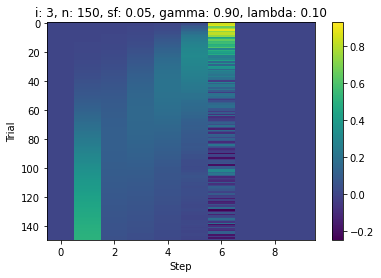

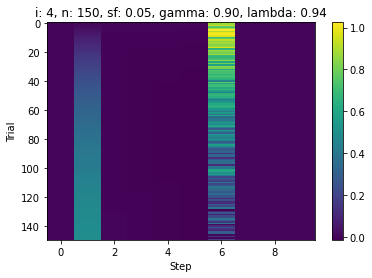

In [31]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "gamma"])

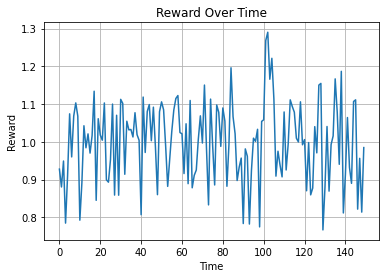

In [32]:
reward(n_trials, r, t_rew)

<h4>Discrete Lambda</h4>

In [33]:
#model params 
gammas = torch.rand(n_predictors, 1) #discount factor 
alpha = 0.05 #learning rate
lmbdas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) # eligibility trace
n_predictors = 50 # number of value predictors

#################################################


steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        r[i, n, step(t_rew[i].item())-1] = gen_rew(tsk)

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

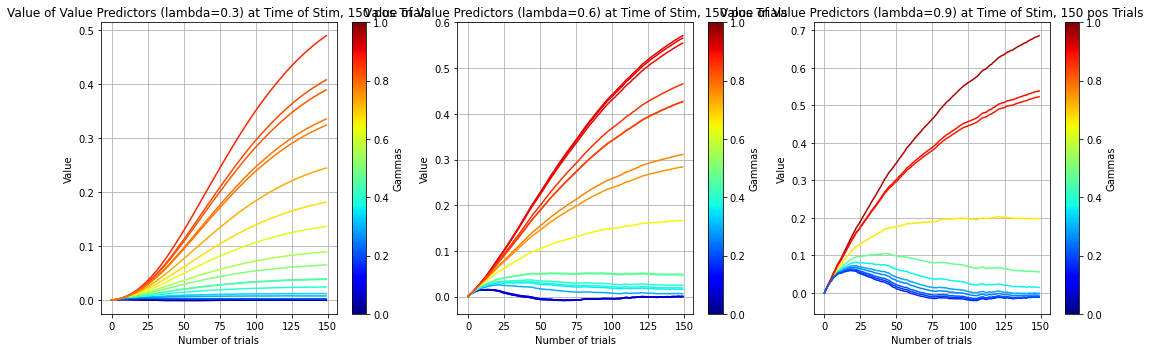

In [34]:
st = 0
predictors = []

tls = [index for index, value in enumerate(states) if value == st]

for i in range(n_predictors):
  value = []
  for s in range(150):
    value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
  predictors.append(value)

# Define the values of scaling factors
lms = [0.3, 0.6, 0.9]

# Create subplots for each gamma value
fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

for i, l in enumerate(lms):
  predictors_sc = []

  # Filter predictors based on the current gamma value
  predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(lmbdas[j].item(), l, 0.1)]

  # Plot the predictors on the corresponding subplot
  axs[i].set_xlabel('Number of trials')
  axs[i].set_ylabel('Value')
  axs[i].set_title(f'Value of Value Predictors (lambda={l}) at Time of Stim, {150} pos Trials')
  axs[i].grid(True)
    
  for j, predictor in enumerate(predictors_sc):
    gm = gammas[predictor[0]].item()
    color = plt.cm.jet(gm)
    axs[i].plot(predictor[1], color=color)

  # Create a colorbar for the current subplot
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=axs[i])
  cbar.set_label('Gammas')

plt.tight_layout()
plt.show()

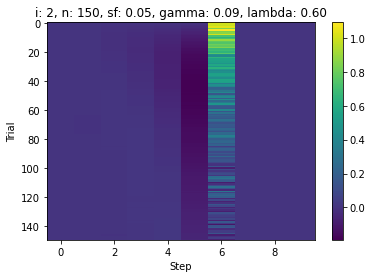

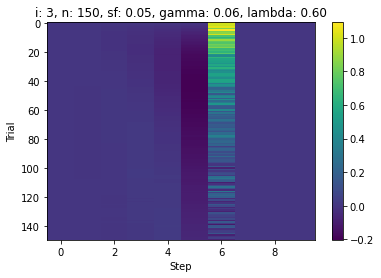

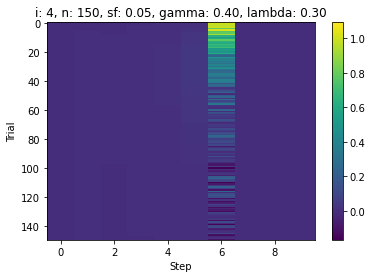

In [35]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "gamma"])

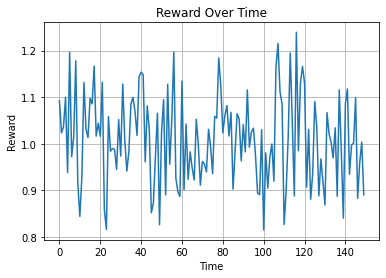

In [36]:
reward(n_trials, r, t_rew)